In [122]:
# importar pacotes
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 

#Sklearnzinhuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuu
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score as R2
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

#cv
%pip install yellowbrick
from sklearn.model_selection import KFold
from yellowbrick.model_selection import CVScores



#configzinhaaaaaaaaaaa
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth', None)

# para conseguir repetir o experimentuuuu
seed = 50
np.random.seed(seed)

Note: you may need to restart the kernel to use updated packages.


#Hello all.

The technical details are found in another file(called `whitepaper_regression.pdf`) found alongside this notebook file.

The models used are Lasso and Ridge. We do a simply routine of feature and target detachment from the original dataset. Furthermore, a simply feature engineering is done to extract more informations. We are not worried about using a lot of features, since mathematically(I mean, theoretically) the models are able to handle it and they even have a shrinkage penalty for non-used features. More details here: https://www.statology.org/when-to-use-ridge-lasso-regression/

We will prove heuristically that our feature space at its totallity is relevant.

In [123]:
df = pd.read_csv(r"C:\Users\victo\Downloads\AB2_formation_energy_materials_spacegroup.csv")
df.drop('Unnamed: 0', axis='columns', inplace=True)
df = df.dropna(axis=1)

In [124]:
target = df['hform']
features = df.drop(columns=['hform', 'Material', 'Space Group'])

In [125]:
def features_words_vectorization(features_list):

    data = features_list

    def tokenize(formula):

        tokens = [formula[i:i+2] for i in range(0, len(formula)-1, 2)]
        return tokens

    vectorizer = TfidfVectorizer(tokenizer=tokenize, lowercase=False)

    tfidf_matrix = vectorizer.fit_transform(data)

    df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
    
    return df



In [126]:
material_vectorization = features_words_vectorization(df['Material'].tolist())
space_vectorization = features_words_vectorization(df['Space Group'].tolist())

C:\Users\victo\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\victo\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [127]:
features = pd.concat([features, material_vectorization, space_vectorization], axis=1)

features_train,features_test = train_test_split(features, test_size = 0.2, random_state = 2)
target_train, target_test = train_test_split(target, test_size = 0.2, random_state = 2)


In [128]:
models = [Lasso, Ridge]

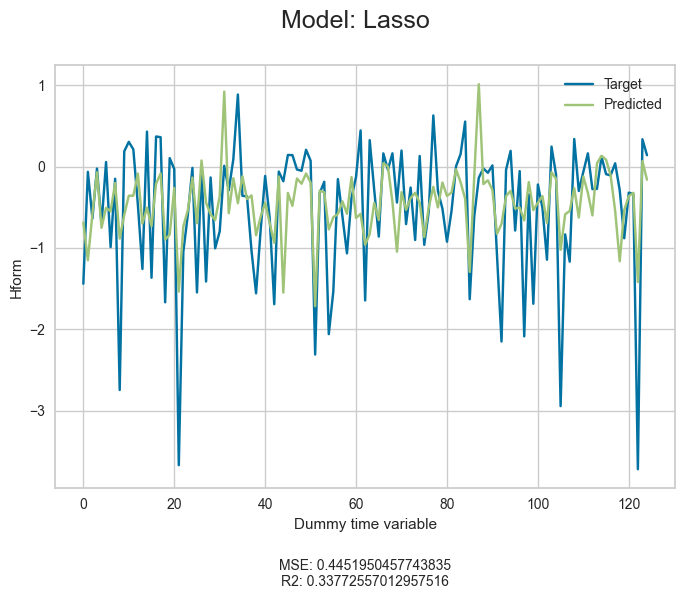

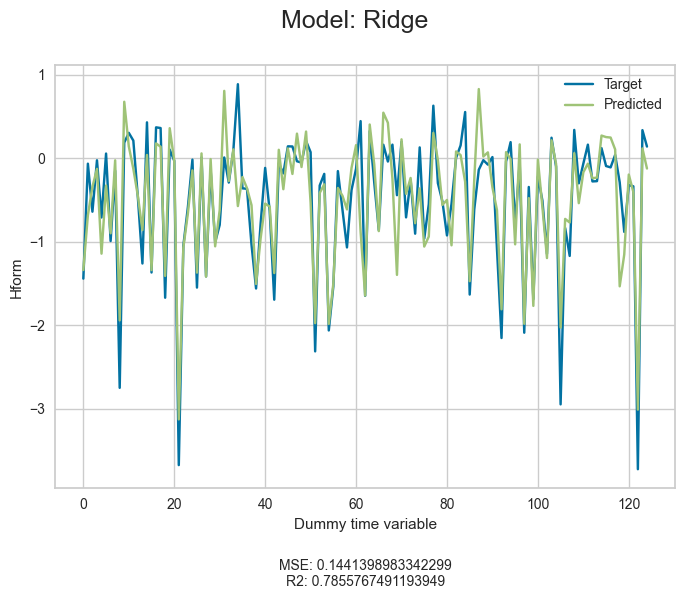

In [129]:
for model in models:
    #
    instance_model = model()
    instance_model.fit(features_train, target_train)
    predicted = instance_model.predict(features_test)
    #
    MSE_calculated_no_selection = MSE(target_test.to_numpy(), predicted)
    R2_calculated_no_selection = R2(target_test.to_numpy(), predicted)
    #
    target_test.squeeze().reset_index(drop=True).plot(label='Target')
    pd.DataFrame(predicted).squeeze().reset_index(drop=True).plot(label='Predicted')
    #
    plt.suptitle('Model: ' + str(model)[-7:-2], fontsize=18)
    plt.title('MSE: ' + str(MSE_calculated_no_selection) + '\nR2: ' + str(R2_calculated_no_selection), fontsize=10, y = -0.25)
    plt.ylabel('Hform')
    plt.xlabel('Dummy time variable')
    plt.legend()
    plt.show()

#And now what?

You might be asking yourself what have I done. I have extracted all the possible features from my dataset regarding the element I am working with and the Space group it belongs. It increases the dataset substantially, so you may get worried, since "the curse of dimensionality", but there is no such thing as "the curse" and I will show you!

The details regarding the possible features extracted by the (initially) string-type features are explained in the pdf sent alongside it.

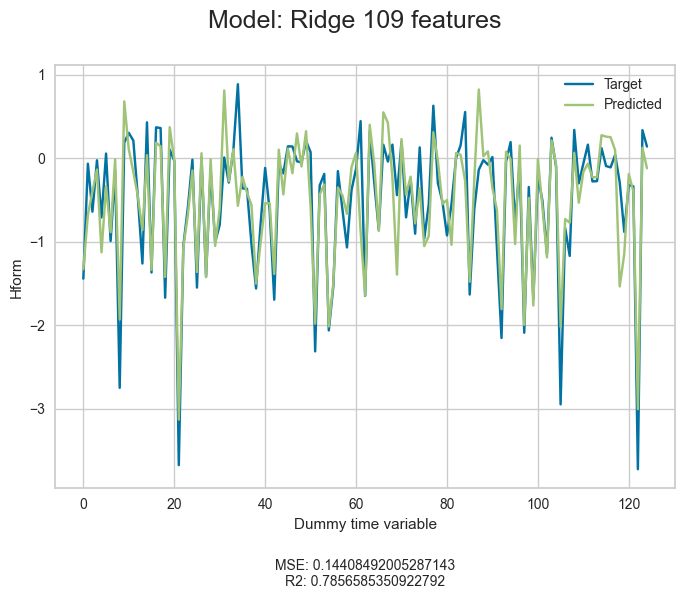

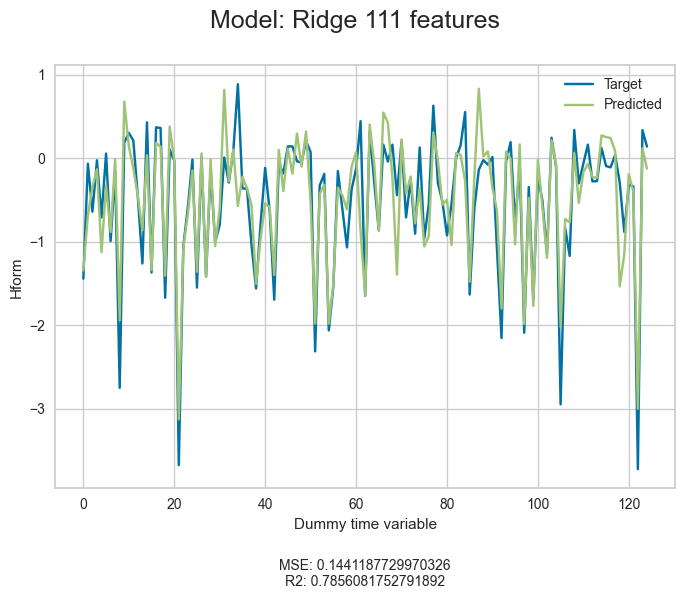

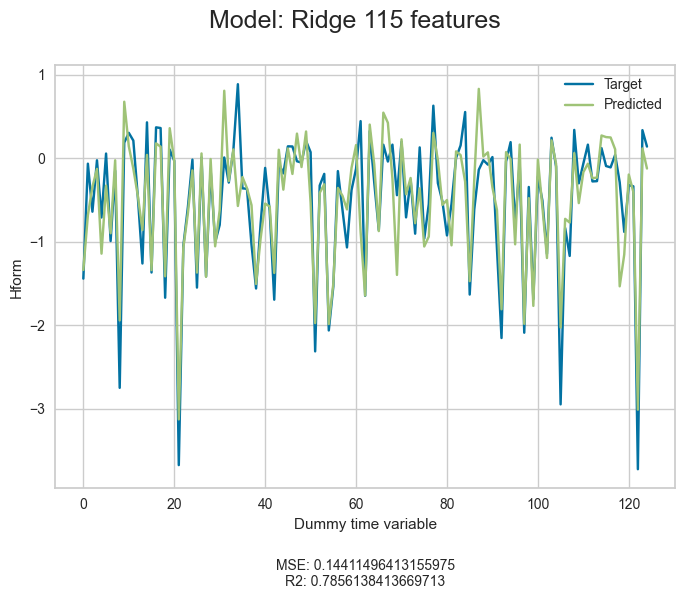

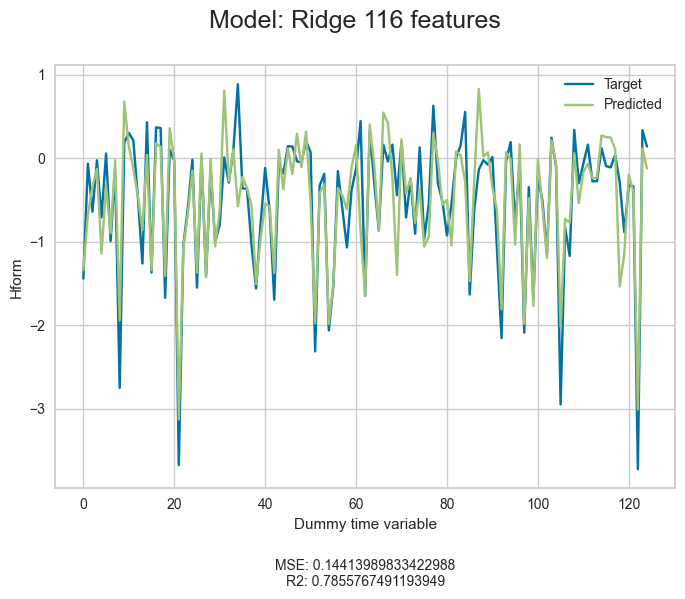

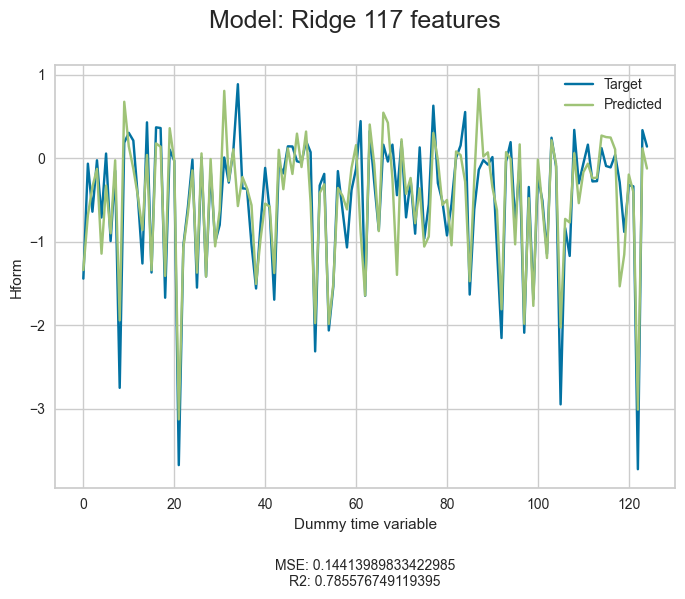

In [130]:
from sklearn.feature_selection import f_regression

for k in range(2, features_train.shape[1]):

    for model in models:
        #
        instance_model = model()
        
        rfe_instance = SelectKBest(f_regression, k=k)
        rfe_instance = rfe_instance.fit(features_train, target_train)
        features_to_use = rfe_instance.get_feature_names_out().tolist()
        
        instance_model.fit(features_train[features_to_use], target_train)

        predicted = instance_model.predict(features_test[features_to_use])
        #
        MSE_calculated = MSE(target_test.to_numpy(), predicted)
        R2_calculated = R2(target_test.to_numpy(), predicted)
        #
        if (MSE_calculated < MSE_calculated_no_selection):
            
            target_test.squeeze().reset_index(drop=True).plot(label='Target')
            pd.DataFrame(predicted).squeeze().reset_index(drop=True).plot(label='Predicted')
            #
            plt.suptitle('Model: ' + str(model)[-7:-2] + ' ' + str(len(features_to_use)) + ' features', fontsize=18)
            plt.title('MSE: ' + str(MSE_calculated) + '\nR2: ' + str(R2_calculated), fontsize=10, y = -0.25)
            plt.ylabel('Hform')
            plt.xlabel('Dummy time variable')
            plt.legend()
            plt.show()
    

#As you may see, no Lasso regressions were better for smaller features spaces than the initially put, although for Ridge, this is true! Notice, however, this happens in a very lesser extension as previously thought, since the MSE is varying almost(if not totally) at a floating-point error.

You(not necessarily you, the reader, but a friend of yours) may accuse me of OVERFITTING, but this is not the case, since the metric is quite the same across our crossvalidation technique

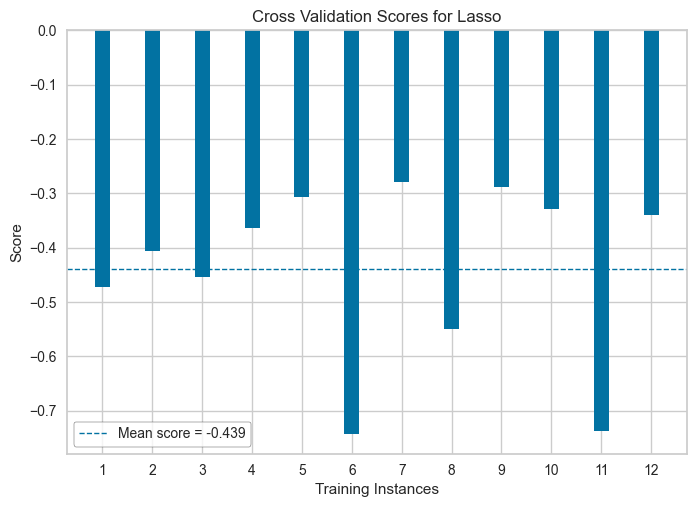

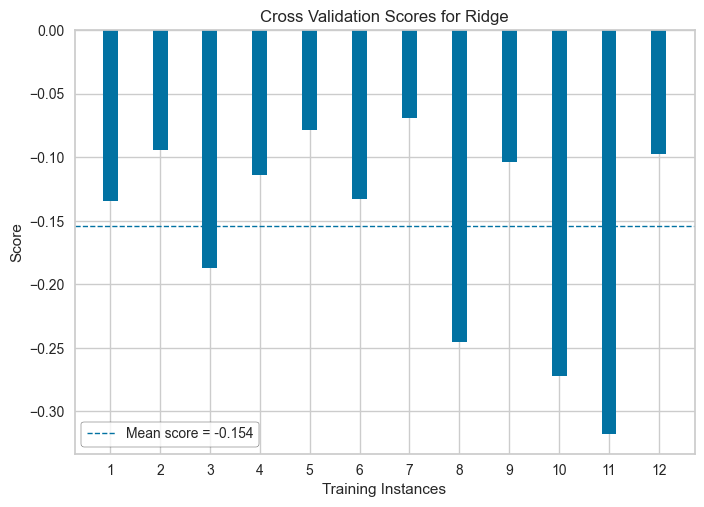

In [131]:
for model in models:
    
    instance_model = model()
    
    cv = KFold(n_splits=12, shuffle=True, random_state=42)
    visualizer = CVScores(instance_model, cv=cv, scoring='neg_mean_squared_error')
    visualizer.fit(features, target)        
    visualizer.show()       


The mean is very similar to the score we got previously for both models regarding the NEG_MSE(the negative sign is just for simplicity in sklearn-API, you may see it without negative sign and lose no generality).

So, we can conclude our feature selection and engineering was sucessfull and our model is not overfitted, ready-to-use in any situation!

Bye.